# Testing for RSA differences 
This notebook shows some of the important issues that arise when trying to 
design an overall omnibus-test to check if there are systematic differences 
in the mean between two samples from two multivariate distributions.

This problem occurs when we want to check if the RSA in two regions are significantly different from each other
or if two connectivity matrices are the same or different. 

Here we focussing on the problem, where the samples come in pairs (x,y)

In [1]:
import os
import numpy as np
import seaborn as sb # for plots
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats as ss # to calcualte confidence intervals, etc
from selective_recruitment import rsa


## Try the cross-correlation (or cosine-similarity) with mean of rest 

Calculate a value for each person by comparing x_1 with the mean of x's from all the other observations
or with the mean of y's from all the other observations. To account for differences in variance between x and y, 
we then do the computation the other way around and average the two values


In [16]:
def test_test_sim_differences_type1(s1=1,s2=1,nsubj=20,niter=1000,P =9):
    """Test for type I error rate in a case where the 
    variability of X1 and X2 is different. 
    """
    m = np.random.normal(0,1,(P,1))
    p = np.zeros((niter,))
    t = np.zeros((niter,))
    for i in range(niter):
        X1 = np.random.normal(0,s1,(nsubj,) + m.shape) + m
        X2 = np.random.normal(0,s2,(nsubj,) + m.shape) + m
        d = rsa.sim_difference_mean(X1,X2)
        t[i],p[i] = ss.ttest_rel(d[:,0], d[:,1],alternative='greater')

    plt.subplot(1,3,1)
    sb.histplot(t)
    plt.axvline(t.mean(),color='k')

    plt.subplot(1,3,2)
    threshold = np.linspace(0.001,0.1,100)
    type1 = np.zeros(threshold.shape)
    for i,th in enumerate(threshold):
        type1[i] = (p<th).sum()/niter
    plt.plot(threshold,type1,'b.')
    plt.plot(threshold,threshold,'k')
    plt.ylabel('Number of Type 1 errors')
    plt.xlabel('Significance threshold')

    ax = plt.subplot(1,3,3)
    ss.probplot(t, dist=ss.t, sparams=(nsubj-1,), plot=ax,fit=False)
    lims = ax.get_xlim()
    plt.plot(lims,lims,'k:')
    pass 

Two problems arise here. 
Even if the two variances are equal, the different observations across subjects are not independent from each other, leading to inflated Type I errors.
Interestingly, the t-values are asymmetric with more false-positive for the totally non-intuitive direction of 
sim_other > sim_same 


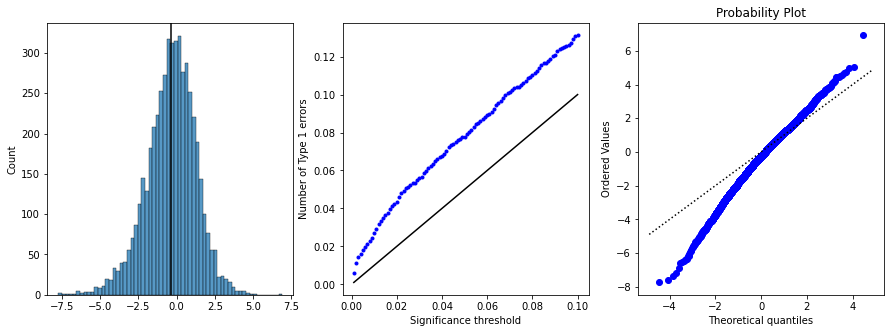

In [14]:
plt.figure(figsize=(15,5))
test_test_sim_differences_type1(s1=1,s2=1,nsubj=20,niter=5000,P=9)

If anything this problem seems to become worse with longer multivariate patterns.... 

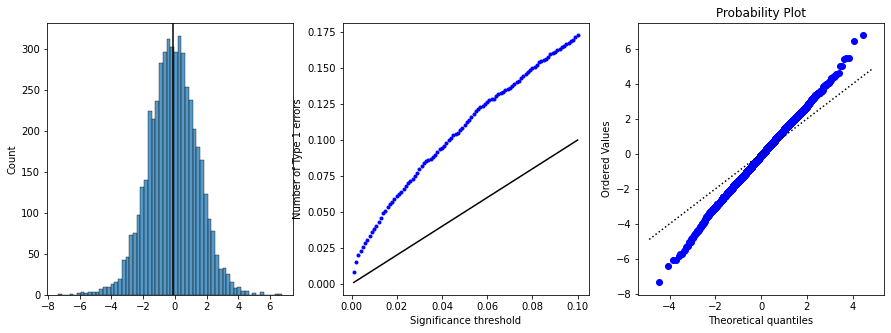

In [17]:
plt.figure(figsize=(15,5))
test_test_sim_differences_type1(s1=1,s2=1,nsubj=20,niter=5000,P=100)

Unforntunately, the statistics is also sensitive to difference in variance in the two samples 

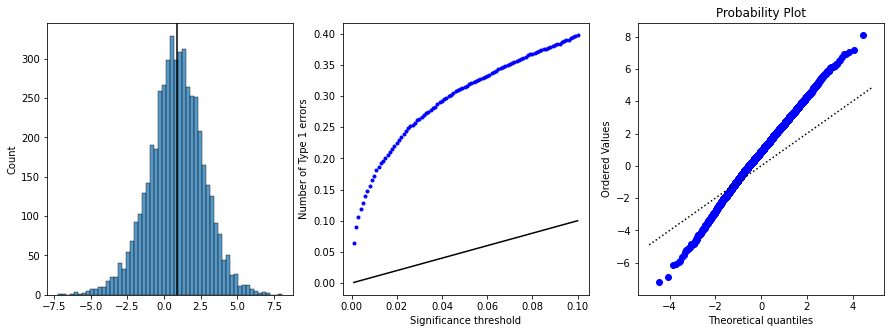

In [19]:
plt.figure(figsize=(15,5))
test_test_sim_differences_type1(s1=1,s2=2,nsubj=20,niter=5000,P=9)

## 2. Maximum mean Discrepancy (MMD)
Obviously, this criterion has quite a bit in common with the MMD statistics (Gretton 2007, section 4)

$MMD^2_u = \frac{1}{N(N-1)} \sum_{i \neq j} \left(  k(x_i,x_j) - 2 k(x_i,y_j) +k(y_i,y_j) \right) $ 

In [23]:
def test_mmd2(s1=1,s2=1,nsubj=20,niter=1000,P =9):
    """Test for type I error rate in a case where the 
    variability of X1 and X2 is different. 
    """
    m = np.random.normal(0,1,(P,1))
    d = np.zeros((niter,))
    for i in range(niter):
        X1 = np.random.normal(0,s1,(nsubj,) + m.shape) + m
        X2 = np.random.normal(0,s2,(nsubj,) + m.shape) + m
        d[i] = rsa.mmd_unbiased_paired(X1,X2)
    sb.histplot(d)
    plt.axvline(d.mean(),color='k')

The test statistics is unbiased and right-skewed. So far so good. 

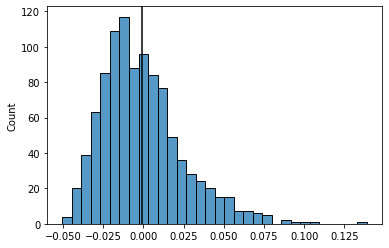

In [28]:
test_mmd2(s1=1,s2=1,P=9)

Unfortunately, it is much more sensitive to the difference in variance between the samples. 
In Gretton (2007), this is actually a desirable feature - here it is not.... 

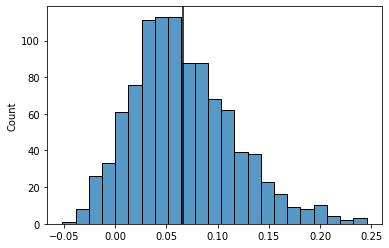

In [29]:
test_mmd2(s1=1,s2=2,P=9)

## 3. Testing for a specific deviation dimension 
One solution would be to use part of the subject to learn a specific deviation direction from linearity, and then test in the second half of the subjects whether this deviation is replicated. 
